In [ ]:
from google.colab import drive
from google.colab.patches import cv2_imshow
from pathlib import Path
import pandas as pd
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import PIL
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import random
import warnings
warnings.filterwarnings("ignore")

In [ ]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
def getDes(Im, tool):
    if tool == 'BRISK':
        source = cv2.BRISK_create()
        #print("BRISK Mode..")
    elif tool == 'SIFT':
        source = cv2.SIFT_create()
        #print("SIFT Mode..")
    elif tool == 'KAZE':
        source = cv2.KAZE_create()
        #print("KAZE Mode..")
    else:
        print("Select a Mode!!")
    img = Im
    kp, des = source.detectAndCompute(img, None)
    return(des)

In [ ]:
def bag_of_features(features, centres, k = 500):
      vec = np.zeros((1, k))
      for i in range(features.shape[0]):
          feat = features[i]
          diff = np.tile(feat, (k, 1)) - centres
          dist = pow(((pow(diff, 2)).sum(axis = 1)), 0.5)
          idx_dist = dist.argsort()
          idx = idx_dist[0]
          vec[0][idx] += 1
      return vec

#SIFT Dengan Augmentasi

##Train Data

Load, preprocessing, dan augmentasi image dan mengambil deskriptor SIFT

In [ ]:
dir = "/content/drive/MyDrive/Kelompok Visi Komputer/dataset/data train/"
folders = ['American craftsman style', 'Art Deco architecture', 'Art Nouveau architecture', 'Baroque architecture',
               'Beaux-Arts architecture', 'Deconstructivism', 'Greek Revival architecture', 'International style',
               'Novelty architecture', 'Queen Anne architecture']
IMAGE_SIZE = (150, 150)
features = []
labels = []
i = 0
counter = 0
def fill(img, h, w):
    return cv2.resize(img, (h, w), cv2.INTER_CUBIC)

for folder in folders:
  folder_dir = dir + folder
  images = Path(folder_dir).glob('*.jpg')
  for image in images:
    if counter < 86:
      image_pp = cv2.imread(str(image))
      image_pp = cv2.resize(image_pp, IMAGE_SIZE)
      image_pp = image_pp / 255.0
      image_pp = cv2.normalize(image_pp, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
      features.append(getDes(image_pp, 'SIFT'))
      labels.append(i)
      img = image_pp
      # Horizontal flip
      img_flip = cv2.flip(img, 1)
      features.append(getDes(img_flip, 'SIFT'))
      labels.append(i)
      # Rotation
      angle = 45
      h, w = img.shape[:2]
      M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
      img_rotate = cv2.warpAffine(img, M, (w, h))
      features.append(getDes(img_rotate, 'SIFT'))
      labels.append(i)
      # Zoom
      value = random.uniform(0.6, 1)
      h, w = img.shape[:2]
      h_taken = int(value*h)
      w_taken = int(value*w)
      h_start = random.randint(0, h-h_taken)
      w_start = random.randint(0, w-w_taken)
      img_con = img[h_start:h_start+h_taken, w_start:w_start+w_taken, :]
      img_zoom = fill(img_con, h, w)
      features.append(getDes(img_zoom, 'SIFT'))
      labels.append(i)
      # Brighness
      value = random.uniform(0.5, 1.4)
      hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
      hsv = np.array(hsv, dtype = np.float64)
      hsv[:,:,1] = hsv[:,:,1]*value
      hsv[:,:,1][hsv[:,:,1]>255]  = 255
      hsv[:,:,2] = hsv[:,:,2]*value
      hsv[:,:,2][hsv[:,:,2]>255]  = 255
      hsv = np.array(hsv, dtype = np.uint8)
      img_bright = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
      features.append(getDes(img_bright, 'SIFT'))
      labels.append(i)
    counter = counter + 1
  i = i + 1
  counter = 0
features = np.vstack(features)

Clustering deskriptor untuk mendapatkan centroid (representasi dari main feature)

In [ ]:
k = 150
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.1)
flags = cv2.KMEANS_RANDOM_CENTERS
compactness, labels2, centres = cv2.kmeans(features, k, None, criteria, 10, flags)

Menggunakan "bag of features" untuk mendapatkan feature vector supaya dapat diinputkan ke model

In [ ]:
dir = "/content/drive/MyDrive/Kelompok Visi Komputer/dataset/data train/"
folders = ['American craftsman style', 'Art Deco architecture', 'Art Nouveau architecture', 'Baroque architecture',
               'Beaux-Arts architecture', 'Deconstructivism', 'Greek Revival architecture', 'International style',
               'Novelty architecture', 'Queen Anne architecture']
vec = []
i = 0
counter = 0
for folder in folders:
  folder_dir = dir + folder
  images = Path(folder_dir).glob('*.jpg')
  for image in images:
    if counter < 86:
      image_pp = cv2.imread(str(image))
      image_pp = cv2.resize(image_pp, IMAGE_SIZE)
      image_pp = image_pp / 255.0
      image_pp = cv2.normalize(image_pp, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
      img_des = getDes(image_pp, 'SIFT')
      if img_des is not None:
        img_vec = bag_of_features(img_des, centres, k)
        vec.append(img_vec)
      img = image_pp
      # Horizontal flip
      img_flip = cv2.flip(img, 1)
      img_des = getDes(img_flip, 'SIFT')
      if img_des is not None:
        img_vec = bag_of_features(img_des, centres, k)
        vec.append(img_vec)
      # Rotation
      angle = 45
      h, w = img.shape[:2]
      M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
      img_rotate = cv2.warpAffine(img, M, (w, h))
      img_des = getDes(img_rotate, 'SIFT')
      if img_des is not None:
        img_vec = bag_of_features(img_des, centres, k)
        vec.append(img_vec)
      # Zoom
      value = random.uniform(0.6, 1)
      h, w = img.shape[:2]
      h_taken = int(value*h)
      w_taken = int(value*w)
      h_start = random.randint(0, h-h_taken)
      w_start = random.randint(0, w-w_taken)
      img_con = img[h_start:h_start+h_taken, w_start:w_start+w_taken, :]
      img_zoom = fill(img_con, h, w)
      img_des = getDes(img_zoom, 'SIFT')
      if img_des is not None:
        img_vec = bag_of_features(img_des, centres, k)
        vec.append(img_vec)
      # Brighness
      value = random.uniform(0.5, 1.4)
      hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
      hsv = np.array(hsv, dtype = np.float64)
      hsv[:,:,1] = hsv[:,:,1]*value
      hsv[:,:,1][hsv[:,:,1]>255]  = 255
      hsv[:,:,2] = hsv[:,:,2]*value
      hsv[:,:,2][hsv[:,:,2]>255]  = 255
      hsv = np.array(hsv, dtype = np.uint8)
      img_bright = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
      img_des = getDes(img_bright, 'SIFT')
      if img_des is not None:
        img_vec = bag_of_features(img_des, centres, k)
        vec.append(img_vec)
    counter = counter + 1
  i = i + 1
  counter = 0
vec = np.vstack(vec)


In [ ]:
X_train = vec
y_train = labels

##Test Data

Mendapatkan "bag of features" menggunakan centroid yang sama dengan train data

In [ ]:
dir = "/content/drive/MyDrive/Kelompok Visi Komputer/dataset/data test/"
folders = ['American craftsman style', 'Art Deco architecture', 'Art Nouveau architecture', 'Baroque architecture',
               'Beaux-Arts architecture', 'Deconstructivism', 'Greek Revival architecture', 'International style',
               'Novelty architecture', 'Queen Anne architecture']
vec = []
labels = []
i = 0
counter = 0
for folder in folders:
  folder_dir = dir + folder
  images = Path(folder_dir).glob('*.jpg')
  for image in images:
    if counter < 36:
      image_pp = cv2.imread(str(image))
      image_pp = cv2.cvtColor(image_pp, cv2.COLOR_BGR2RGB)
      image_pp = cv2.resize(image_pp, IMAGE_SIZE)
      image_pp = image_pp / 255.0
      image_pp = cv2.normalize(image_pp, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
      img_des = getDes(image_pp, 'SIFT')
      if img_des is not None:
        img_vec = bag_of_features(img_des, centres, k)
        vec.append(img_vec)
      labels.append(i)
    counter = counter + 1
  i = i + 1
  counter = 0
vec = np.vstack(vec)


In [ ]:
X_test = vec
y_test = labels

##Training Model dan Evaluasi

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

###SVC

In [ ]:
clf = SVC()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
acc = accuracy_score(y_test, preds)
conf_mat = confusion_matrix(y_test, preds)

              precision    recall  f1-score   support

           0       0.28      0.31      0.29        36
           1       0.20      0.08      0.12        36
           2       0.29      0.17      0.21        36
           3       0.24      0.28      0.26        36
           4       0.37      0.31      0.33        36
           5       0.27      0.36      0.31        36
           6       0.42      0.50      0.46        36
           7       0.59      0.47      0.52        36
           8       0.24      0.39      0.30        36
           9       0.26      0.25      0.26        36

    accuracy                           0.31       360
   macro avg       0.31      0.31      0.31       360
weighted avg       0.31      0.31      0.31       360

Confusion matrix, without normalization
[[11  0  0  2  0  0  5  1  5 12]
 [ 2  3  4  5  6  3  3  4  3  3]
 [ 2  5  6  8  4  1  1  1  3  5]
 [ 3  2  3 10  4  3  4  0  7  0]
 [ 0  1  6  7 11  0  6  1  1  3]
 [ 1  0  0  1  0 13  0  3 18  0]
 [ 

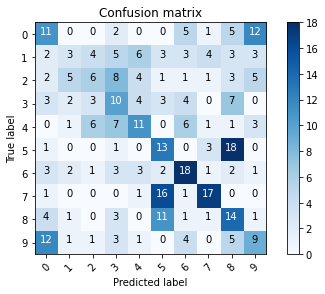

In [ ]:
np.set_printoptions(precision=2)

print (classification_report(y_test, preds))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=['0','1','2','3','4','5','6','7','8','9'],normalize= False,  title='Confusion matrix')

###Logistic Regression Grid Search

In [ ]:
param_grid = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
logreg=LogisticRegression()
model=GridSearchCV(logreg,param_grid)

In [ ]:
model.fit(X_train, y_train)
preds = model.predict(X_test)
acc = accuracy_score(y_test, preds)
conf_mat = confusion_matrix(y_test, preds)

              precision    recall  f1-score   support

           0       0.38      0.31      0.34        36
           1       0.25      0.14      0.18        36
           2       0.17      0.11      0.14        36
           3       0.25      0.31      0.28        36
           4       0.42      0.28      0.33        36
           5       0.30      0.39      0.34        36
           6       0.41      0.53      0.46        36
           7       0.51      0.56      0.53        36
           8       0.33      0.53      0.41        36
           9       0.32      0.28      0.30        36

    accuracy                           0.34       360
   macro avg       0.33      0.34      0.33       360
weighted avg       0.33      0.34      0.33       360

Confusion matrix, without normalization
[[11  1  0  2  0  1  5  2  4 10]
 [ 1  5  5  3  6  4  4  3  4  1]
 [ 1  7  4 10  2  2  1  1  2  6]
 [ 3  1  4 11  3  4  4  1  5  0]
 [ 0  2  6  9 10  0  6  1  0  2]
 [ 1  0  0  0  0 14  1  6 14  0]
 [ 

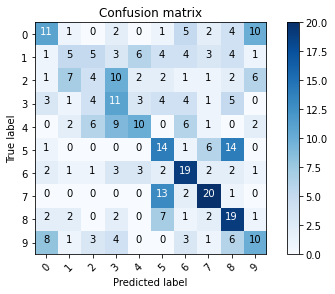

In [ ]:
np.set_printoptions(precision=2)

print (classification_report(y_test, preds))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=['0','1','2','3','4','5','6','7','8','9'],normalize= False,  title='Confusion matrix')

###Random Forest

In [ ]:
model = RandomForestClassifier(50, max_depth=15, max_features=15)
model.fit(X_train, y_train)
preds = model.predict(X_test)
acc = accuracy_score(y_test, preds)
conf_mat = confusion_matrix(y_test, preds)

              precision    recall  f1-score   support

           0       0.42      0.39      0.41        36
           1       0.17      0.06      0.08        36
           2       0.30      0.17      0.21        36
           3       0.22      0.33      0.26        36
           4       0.38      0.25      0.30        36
           5       0.29      0.50      0.37        36
           6       0.23      0.28      0.25        36
           7       0.48      0.36      0.41        36
           8       0.25      0.36      0.30        36
           9       0.30      0.28      0.29        36

    accuracy                           0.30       360
   macro avg       0.30      0.30      0.29       360
weighted avg       0.30      0.30      0.29       360

Confusion matrix, without normalization
[[14  0  0  2  0  4  5  1  4  6]
 [ 3  2  4  1  3  4  5  5  5  4]
 [ 3  2  6 10  5  3  3  0  2  2]
 [ 0  2  3 12  1  2  8  1  5  2]
 [ 0  1  5 11  9  0  6  0  0  4]
 [ 0  0  0  1  0 18  0  2 15  0]
 [ 

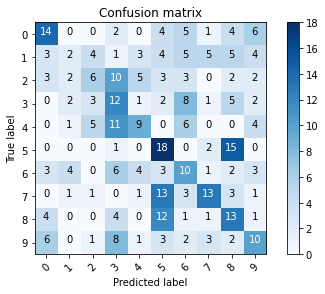

In [ ]:
np.set_printoptions(precision=2)

print (classification_report(y_test, preds))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=['0','1','2','3','4','5','6','7','8','9'],normalize= False,  title='Confusion matrix')

###XGBoost Grid Search

In [ ]:
xgbc = XGBClassifier(objective='multiclass:softmax', learning_rate = 0.1,
              max_depth = 1, n_estimators = 330)
param_grid={'learning_rate':[0.1,0.2,0.3,0.4,0.5,0.6]}

xgbc_g=GridSearchCV(xgbc,param_grid)
xgbc_g.fit(X_train, y_train)
preds_xgbc_g = xgbc_g.predict(X_test)

              precision    recall  f1-score   support

           0       0.37      0.36      0.37        36
           1       0.14      0.08      0.10        36
           2       0.20      0.14      0.16        36
           3       0.28      0.31      0.29        36
           4       0.30      0.22      0.25        36
           5       0.33      0.36      0.34        36
           6       0.33      0.42      0.37        36
           7       0.51      0.50      0.51        36
           8       0.29      0.50      0.37        36
           9       0.40      0.33      0.36        36

    accuracy                           0.32       360
   macro avg       0.31      0.32      0.31       360
weighted avg       0.31      0.32      0.31       360

Confusion matrix, without normalization
[[14  0  0  2  0  4  5  1  4  6]
 [ 3  2  4  1  3  4  5  5  5  4]
 [ 3  2  6 10  5  3  3  0  2  2]
 [ 0  2  3 12  1  2  8  1  5  2]
 [ 0  1  5 11  9  0  6  0  0  4]
 [ 0  0  0  1  0 18  0  2 15  0]
 [ 

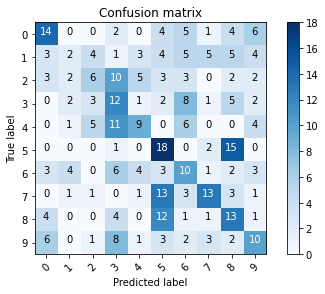

In [ ]:
np.set_printoptions(precision=2)

print (classification_report(y_test, preds_xgbc_g))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=['0','1','2','3','4','5','6','7','8','9'],normalize= False,  title='Confusion matrix')

#SIFT Tanpa Augmentasi

##Train Data

In [ ]:
dir = "/content/drive/MyDrive/Kelompok Visi Komputer/dataset/data train/"
folders = ['American craftsman style', 'Art Deco architecture', 'Art Nouveau architecture', 'Baroque architecture',
               'Beaux-Arts architecture', 'Deconstructivism', 'Greek Revival architecture', 'International style',
               'Novelty architecture', 'Queen Anne architecture']
IMAGE_SIZE = (150, 150)
features = []
labels = []
i = 0
counter = 0
for folder in folders:
  folder_dir = dir + folder
  images = Path(folder_dir).glob('*.jpg')
  for image in images:
    if counter < 86:
      image_pp = cv2.imread(str(image))
      image_pp = cv2.resize(image_pp, IMAGE_SIZE)
      image_pp = image_pp / 255.0
      image_pp = cv2.normalize(image_pp, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
      features.append(getDes(image_pp, 'SIFT'))
      labels.append(i)
    counter = counter + 1
  i = i + 1
  counter = 0
features = np.vstack(features)

In [ ]:
k = 150
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.1)
flags = cv2.KMEANS_RANDOM_CENTERS
compactness, labels2, centres = cv2.kmeans(features, k, None, criteria, 10, flags)

In [ ]:
dir = "/content/drive/MyDrive/Kelompok Visi Komputer/dataset/data train/"
folders = ['American craftsman style', 'Art Deco architecture', 'Art Nouveau architecture', 'Baroque architecture',
               'Beaux-Arts architecture', 'Deconstructivism', 'Greek Revival architecture', 'International style',
               'Novelty architecture', 'Queen Anne architecture']
vec = []
i = 0
counter = 0
for folder in folders:
  folder_dir = dir + folder
  images = Path(folder_dir).glob('*.jpg')
  for image in images:
    if counter < 86:
      image_pp = cv2.imread(str(image))
      image_pp = cv2.resize(image_pp, IMAGE_SIZE)
      image_pp = image_pp / 255.0
      image_pp = cv2.normalize(image_pp, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
      img_des = getDes(image_pp, 'SIFT')
      if img_des is not None:
        img_vec = bag_of_features(img_des, centres, k)
        vec.append(img_vec)
    counter = counter + 1
  i = i + 1
  counter = 0
vec = np.vstack(vec)


In [ ]:
X_train = vec
y_train = labels

##Test Data

In [ ]:
dir = "/content/drive/MyDrive/Kelompok Visi Komputer/dataset/data test/"
folders = ['American craftsman style', 'Art Deco architecture', 'Art Nouveau architecture', 'Baroque architecture',
               'Beaux-Arts architecture', 'Deconstructivism', 'Greek Revival architecture', 'International style',
               'Novelty architecture', 'Queen Anne architecture']
vec = []
labels = []
i = 0
counter = 0
for folder in folders:
  folder_dir = dir + folder
  images = Path(folder_dir).glob('*.jpg')
  for image in images:
    if counter < 36:
      image_pp = cv2.imread(str(image))
      image_pp = cv2.cvtColor(image_pp, cv2.COLOR_BGR2RGB)
      image_pp = cv2.resize(image_pp, IMAGE_SIZE)
      image_pp = image_pp / 255.0
      image_pp = cv2.normalize(image_pp, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
      img_des = getDes(image_pp, 'SIFT')
      if img_des is not None:
        img_vec = bag_of_features(img_des, centres, k)
        vec.append(img_vec)
      labels.append(i)
    counter = counter + 1
  i = i + 1
  counter = 0
vec = np.vstack(vec)


In [ ]:
X_test = vec
y_test = labels

##Training Model dan Evaluasi

###SVC

In [ ]:
clf = SVC()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
acc = accuracy_score(y_test, preds)
conf_mat = confusion_matrix(y_test, preds)

              precision    recall  f1-score   support

           0       0.30      0.42      0.35        36
           1       0.17      0.08      0.11        36
           2       0.23      0.17      0.19        36
           3       0.35      0.33      0.34        36
           4       0.37      0.28      0.32        36
           5       0.32      0.50      0.39        36
           6       0.44      0.42      0.43        36
           7       0.62      0.50      0.55        36
           8       0.33      0.47      0.39        36
           9       0.41      0.39      0.40        36

    accuracy                           0.36       360
   macro avg       0.35      0.36      0.35       360
weighted avg       0.35      0.36      0.35       360

Confusion matrix, without normalization
[[15  1  0  1  1  1  5  0  7  5]
 [ 4  3  6  4  3  2  3  4  5  2]
 [ 2  9  6  5  4  1  0  0  2  7]
 [ 4  0  2 12  3  6  4  1  3  1]
 [ 2  1 10  5 10  0  4  2  0  2]
 [ 2  0  0  0  2 18  1  3 10  0]
 [ 

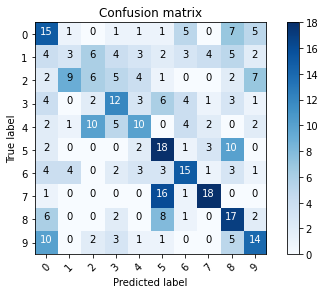

In [ ]:
np.set_printoptions(precision=2)

print (classification_report(y_test, preds))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=['0','1','2','3','4','5','6','7','8','9'],normalize= False,  title='Confusion matrix')

###Logistic Regression Grid Search

In [ ]:
param_grid = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
logreg=LogisticRegression()
model=GridSearchCV(logreg,param_grid)

In [ ]:
model.fit(X_train, y_train)
preds = model.predict(X_test)
acc = accuracy_score(y_test, preds)
conf_mat = confusion_matrix(y_test, preds)

              precision    recall  f1-score   support

           0       0.34      0.42      0.37        36
           1       0.23      0.14      0.17        36
           2       0.23      0.19      0.21        36
           3       0.32      0.28      0.30        36
           4       0.20      0.17      0.18        36
           5       0.27      0.42      0.33        36
           6       0.30      0.25      0.27        36
           7       0.54      0.53      0.54        36
           8       0.25      0.39      0.30        36
           9       0.36      0.25      0.30        36

    accuracy                           0.30       360
   macro avg       0.30      0.30      0.30       360
weighted avg       0.30      0.30      0.30       360

Confusion matrix, without normalization
[[15  0  0  1  1  0  8  0  6  5]
 [ 1  5  8  2  6  3  2  4  4  1]
 [ 1  8  7  3  4  2  2  1  2  6]
 [ 4  1  6 10  3  3  2  2  5  0]
 [ 2  4  8  8  6  1  3  3  0  1]
 [ 2  0  0  0  1 15  0  4 13  1]
 [ 

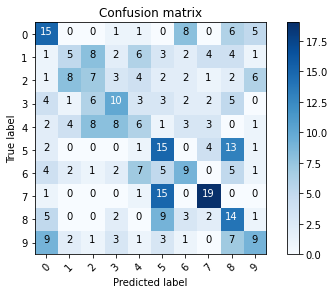

In [ ]:
np.set_printoptions(precision=2)

print (classification_report(y_test, preds))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=['0','1','2','3','4','5','6','7','8','9'],normalize= False,  title='Confusion matrix')

###Random Forest

In [ ]:
model = RandomForestClassifier(50, max_depth=15, max_features=15)
model.fit(X_train, y_train)
preds = model.predict(X_test)
acc = accuracy_score(y_test, preds)
conf_mat = confusion_matrix(y_test, preds)

              precision    recall  f1-score   support

           0       0.38      0.36      0.37        36
           1       0.27      0.19      0.23        36
           2       0.26      0.19      0.22        36
           3       0.23      0.22      0.23        36
           4       0.08      0.06      0.06        36
           5       0.36      0.58      0.44        36
           6       0.23      0.28      0.25        36
           7       0.46      0.33      0.39        36
           8       0.20      0.28      0.24        36
           9       0.17      0.17      0.17        36

    accuracy                           0.27       360
   macro avg       0.26      0.27      0.26       360
weighted avg       0.26      0.27      0.26       360

Confusion matrix, without normalization
[[13  1  0  0  0  1  5  1  5 10]
 [ 0  7  3  5  6  1  5  3  5  1]
 [ 3  6  7  5  3  1  3  0  3  5]
 [ 1  0  3  8  6  6  7  1  4  0]
 [ 0  6  9  9  2  0  5  1  0  4]
 [ 1  0  0  2  0 21  1  3  8  0]
 [ 

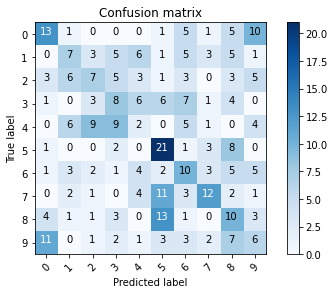

In [ ]:
np.set_printoptions(precision=2)

print (classification_report(y_test, preds))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=['0','1','2','3','4','5','6','7','8','9'],normalize= False,  title='Confusion matrix')

###XGBoost Grid Search

In [ ]:
xgbc = XGBClassifier(objective='multiclass:softmax', learning_rate = 0.1,
              max_depth = 1, n_estimators = 330)
param_grid={'learning_rate':[0.1,0.2,0.3,0.4,0.5,0.6]}

xgbc_g=GridSearchCV(xgbc,param_grid)
xgbc_g.fit(X_train, y_train)
preds_xgbc_g = xgbc_g.predict(X_test)

              precision    recall  f1-score   support

           0       0.41      0.42      0.41        36
           1       0.15      0.11      0.13        36
           2       0.12      0.08      0.10        36
           3       0.29      0.28      0.29        36
           4       0.24      0.25      0.24        36
           5       0.28      0.44      0.34        36
           6       0.33      0.31      0.32        36
           7       0.56      0.56      0.56        36
           8       0.24      0.31      0.27        36
           9       0.36      0.28      0.31        36

    accuracy                           0.30       360
   macro avg       0.30      0.30      0.30       360
weighted avg       0.30      0.30      0.30       360

Confusion matrix, without normalization
[[13  1  0  0  0  1  5  1  5 10]
 [ 0  7  3  5  6  1  5  3  5  1]
 [ 3  6  7  5  3  1  3  0  3  5]
 [ 1  0  3  8  6  6  7  1  4  0]
 [ 0  6  9  9  2  0  5  1  0  4]
 [ 1  0  0  2  0 21  1  3  8  0]
 [ 

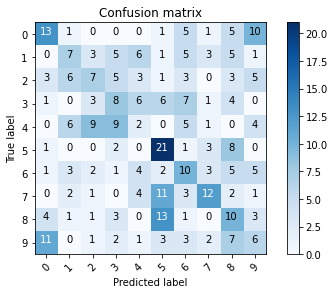

In [ ]:
np.set_printoptions(precision=2)

print (classification_report(y_test, preds_xgbc_g))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=['0','1','2','3','4','5','6','7','8','9'],normalize= False,  title='Confusion matrix')

#BRISK Dengan Augmentasi

##Train Data

In [ ]:
dir = "/content/drive/MyDrive/Kelompok Visi Komputer/dataset/data train/"
folders = ['American craftsman style', 'Art Deco architecture', 'Art Nouveau architecture', 'Baroque architecture',
               'Beaux-Arts architecture', 'Deconstructivism', 'Greek Revival architecture', 'International style',
               'Novelty architecture', 'Queen Anne architecture']
IMAGE_SIZE = (150, 150)
features = []
labels = []
i = 0
counter = 0
for folder in folders:
  folder_dir = dir + folder
  images = Path(folder_dir).glob('*.jpg')
  for image in images:
    if counter < 86:
      image_pp = cv2.imread(str(image))
      image_pp = cv2.resize(image_pp, IMAGE_SIZE)
      image_pp = image_pp / 255.0
      image_pp = cv2.normalize(image_pp, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
      features.append(np.float32(getDes(image_pp, 'BRISK')))
      labels.append(i)
      img = image_pp
      # Horizontal flip
      img_flip = cv2.flip(img, 1)
      features.append(np.float32(getDes(img_flip, 'BRISK')))
      labels.append(i)
      # Rotation
      angle = 45
      h, w = img.shape[:2]
      M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
      img_rotate = cv2.warpAffine(img, M, (w, h))
      features.append(np.float32(getDes(img_rotate, 'BRISK')))
      labels.append(i)
      # Zoom
      value = random.uniform(0.6, 1)
      h, w = img.shape[:2]
      h_taken = int(value*h)
      w_taken = int(value*w)
      h_start = random.randint(0, h-h_taken)
      w_start = random.randint(0, w-w_taken)
      img_con = img[h_start:h_start+h_taken, w_start:w_start+w_taken, :]
      img_zoom = fill(img_con, h, w)
      features.append(np.float32(getDes(img_zoom, 'BRISK')))
      labels.append(i)
      # Brighness
      value = random.uniform(0.5, 1.4)
      hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
      hsv = np.array(hsv, dtype = np.float64)
      hsv[:,:,1] = hsv[:,:,1]*value
      hsv[:,:,1][hsv[:,:,1]>255]  = 255
      hsv[:,:,2] = hsv[:,:,2]*value
      hsv[:,:,2][hsv[:,:,2]>255]  = 255
      hsv = np.array(hsv, dtype = np.uint8)
      img_bright = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
      features.append(np.float32(getDes(img_bright, 'BRISK')))
      labels.append(i)
    counter = counter + 1
  i = i + 1
  counter = 0
features = np.vstack(features)

In [ ]:
k = 150
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.1)
flags = cv2.KMEANS_RANDOM_CENTERS
compactness, labels2, centres = cv2.kmeans(features, k, None, criteria, 10, flags)

In [ ]:
dir = "/content/drive/MyDrive/Kelompok Visi Komputer/dataset/data train/"
folders = ['American craftsman style', 'Art Deco architecture', 'Art Nouveau architecture', 'Baroque architecture',
               'Beaux-Arts architecture', 'Deconstructivism', 'Greek Revival architecture', 'International style',
               'Novelty architecture', 'Queen Anne architecture']
vec = []
i = 0
counter = 0
for folder in folders:
  folder_dir = dir + folder
  images = Path(folder_dir).glob('*.jpg')
  for image in images:
    if counter < 86:
      image_pp = cv2.imread(str(image))
      image_pp = cv2.resize(image_pp, IMAGE_SIZE)
      image_pp = image_pp / 255.0
      image_pp = cv2.normalize(image_pp, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
      img_des = getDes(image_pp, 'BRISK')
      if img_des is not None:
        img_vec = bag_of_features(img_des, centres, k)
        vec.append(img_vec)
      img = image_pp
      # Horizontal flip
      img_flip = cv2.flip(img, 1)
      img_des = getDes(img_flip, 'BRISK')
      if img_des is not None:
        img_vec = bag_of_features(img_des, centres, k)
        vec.append(img_vec)
      # Rotation
      angle = 45
      h, w = img.shape[:2]
      M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
      img_rotate = cv2.warpAffine(img, M, (w, h))
      img_des = getDes(img_rotate, 'BRISK')
      if img_des is not None:
        img_vec = bag_of_features(img_des, centres, k)
        vec.append(img_vec)
      # Zoom
      value = random.uniform(0.6, 1)
      h, w = img.shape[:2]
      h_taken = int(value*h)
      w_taken = int(value*w)
      h_start = random.randint(0, h-h_taken)
      w_start = random.randint(0, w-w_taken)
      img_con = img[h_start:h_start+h_taken, w_start:w_start+w_taken, :]
      img_zoom = fill(img_con, h, w)
      img_des = getDes(img_zoom, 'BRISK')
      if img_des is not None:
        img_vec = bag_of_features(img_des, centres, k)
        vec.append(img_vec)
      # Brighness
      value = random.uniform(0.5, 1.4)
      hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
      hsv = np.array(hsv, dtype = np.float64)
      hsv[:,:,1] = hsv[:,:,1]*value
      hsv[:,:,1][hsv[:,:,1]>255]  = 255
      hsv[:,:,2] = hsv[:,:,2]*value
      hsv[:,:,2][hsv[:,:,2]>255]  = 255
      hsv = np.array(hsv, dtype = np.uint8)
      img_bright = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
      img_des = getDes(img_bright, 'BRISK')
      if img_des is not None:
        img_vec = bag_of_features(img_des, centres, k)
        vec.append(img_vec)
    counter = counter + 1
  i = i + 1
  counter = 0
vec = np.vstack(vec)


In [ ]:
X_train = vec
y_train = labels

##Test Data

In [ ]:
dir = "/content/drive/MyDrive/Kelompok Visi Komputer/dataset/data test/"
folders = ['American craftsman style', 'Art Deco architecture', 'Art Nouveau architecture', 'Baroque architecture',
               'Beaux-Arts architecture', 'Deconstructivism', 'Greek Revival architecture', 'International style',
               'Novelty architecture', 'Queen Anne architecture']
vec = []
labels = []
i = 0
counter = 0
for folder in folders:
  folder_dir = dir + folder
  images = Path(folder_dir).glob('*.jpg')
  for image in images:
    if counter < 36:
      image_pp = cv2.imread(str(image))
      image_pp = cv2.cvtColor(image_pp, cv2.COLOR_BGR2RGB)
      image_pp = cv2.resize(image_pp, IMAGE_SIZE)
      image_pp = image_pp / 255.0
      image_pp = cv2.normalize(image_pp, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
      img_des = getDes(image_pp, 'BRISK')
      if img_des is not None:
        img_vec = bag_of_features(img_des, centres, k)
        vec.append(img_vec)
      labels.append(i)
    counter = counter + 1
  i = i + 1
  counter = 0
vec = np.vstack(vec)


In [ ]:
X_test = vec
y_test = labels

##Training Model dan Evaluasi

###SVC

In [ ]:
clf = SVC()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
acc = accuracy_score(y_test, preds)
conf_mat = confusion_matrix(y_test, preds)

              precision    recall  f1-score   support

           0       0.33      0.36      0.35        36
           1       0.20      0.11      0.14        36
           2       0.18      0.28      0.22        36
           3       0.28      0.22      0.25        36
           4       0.26      0.14      0.18        36
           5       0.45      0.50      0.47        36
           6       0.48      0.28      0.35        36
           7       0.57      0.56      0.56        36
           8       0.23      0.28      0.25        36
           9       0.33      0.53      0.40        36

    accuracy                           0.33       360
   macro avg       0.33      0.33      0.32       360
weighted avg       0.33      0.33      0.32       360

Confusion matrix, without normalization
[[13  0  2  1  0  1  2  0  2 15]
 [ 2  4 13  3  2  1  2  4  2  3]
 [ 2  3 10  5  5  2  1  3  1  4]
 [ 3  2  5  8  5  2  1  0  5  5]
 [ 0  0 18  6  5  1  0  3  0  3]
 [ 3  1  0  0  0 18  1  2 10  1]
 [ 

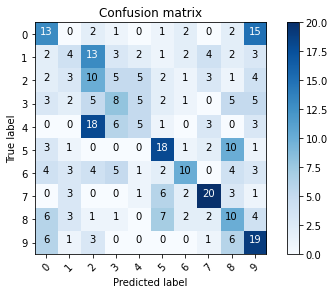

In [ ]:
np.set_printoptions(precision=2)

print (classification_report(y_test, preds))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=['0','1','2','3','4','5','6','7','8','9'],normalize= False,  title='Confusion matrix')

###Logistic Regression Grid Search

In [ ]:
param_grid = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
logreg=LogisticRegression()
model=GridSearchCV(logreg,param_grid)

In [ ]:
model.fit(X_train, y_train)
preds = model.predict(X_test)
acc = accuracy_score(y_test, preds)
conf_mat = confusion_matrix(y_test, preds)

              precision    recall  f1-score   support

           0       0.33      0.42      0.37        36
           1       0.26      0.17      0.20        36
           2       0.14      0.17      0.15        36
           3       0.21      0.19      0.20        36
           4       0.19      0.17      0.18        36
           5       0.18      0.17      0.17        36
           6       0.50      0.33      0.40        36
           7       0.61      0.53      0.57        36
           8       0.23      0.33      0.27        36
           9       0.33      0.39      0.36        36

    accuracy                           0.29       360
   macro avg       0.30      0.29      0.29       360
weighted avg       0.30      0.29      0.29       360

Confusion matrix, without normalization
[[15  0  0  4  0  1  2  0  2 12]
 [ 3  6 11  3  3  2  1  1  2  4]
 [ 5  4  6  5  6  4  1  1  2  2]
 [ 2  2  4  7  6  3  1  1  6  4]
 [ 0  1 15  6  6  0  2  4  0  2]
 [ 3  2  1  1  1  6  2  3 17  0]
 [ 

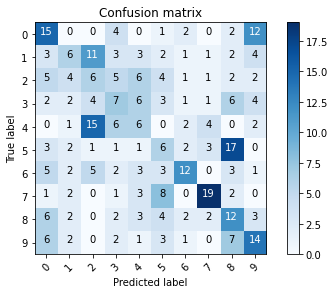

In [ ]:
np.set_printoptions(precision=2)

print (classification_report(y_test, preds))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=['0','1','2','3','4','5','6','7','8','9'],normalize= False,  title='Confusion matrix')

###Random Forest

In [ ]:
model = RandomForestClassifier(50, max_depth=15, max_features=15)
model.fit(X_train, y_train)
preds = model.predict(X_test)
acc = accuracy_score(y_test, preds)
conf_mat = confusion_matrix(y_test, preds)

              precision    recall  f1-score   support

           0       0.22      0.31      0.25        36
           1       0.14      0.08      0.10        36
           2       0.15      0.19      0.17        36
           3       0.13      0.11      0.12        36
           4       0.17      0.08      0.11        36
           5       0.35      0.33      0.34        36
           6       0.33      0.31      0.32        36
           7       0.73      0.44      0.55        36
           8       0.24      0.25      0.24        36
           9       0.28      0.50      0.36        36

    accuracy                           0.26       360
   macro avg       0.27      0.26      0.26       360
weighted avg       0.27      0.26      0.26       360

Confusion matrix, without normalization
[[11  0  2  2  1  1  2  0  3 14]
 [11  3  9  2  2  0  5  1  1  2]
 [ 2  4  7  5  5  2  1  1  1  8]
 [ 5  2  5  4  4  2  2  1  2  9]
 [ 0  4 16  8  3  1  2  0  2  0]
 [ 6  1  1  0  0 12  4  0 10  2]
 [ 

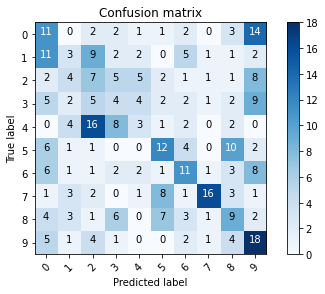

In [ ]:
np.set_printoptions(precision=2)

print (classification_report(y_test, preds))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=['0','1','2','3','4','5','6','7','8','9'],normalize= False,  title='Confusion matrix')

###XGBoost Grid Search

In [ ]:
xgbc = XGBClassifier(objective='multiclass:softmax', learning_rate = 0.1,
              max_depth = 1, n_estimators = 330)
param_grid={'learning_rate':[0.1,0.2,0.3,0.4,0.5,0.6]}

xgbc_g=GridSearchCV(xgbc,param_grid)
xgbc_g.fit(X_train, y_train)
preds_xgbc_g = xgbc_g.predict(X_test)

              precision    recall  f1-score   support

           0       0.28      0.33      0.30        36
           1       0.17      0.11      0.14        36
           2       0.15      0.19      0.17        36
           3       0.21      0.19      0.20        36
           4       0.22      0.17      0.19        36
           5       0.29      0.22      0.25        36
           6       0.39      0.31      0.34        36
           7       0.58      0.53      0.55        36
           8       0.20      0.28      0.24        36
           9       0.25      0.33      0.29        36

    accuracy                           0.27       360
   macro avg       0.27      0.27      0.27       360
weighted avg       0.27      0.27      0.27       360

Confusion matrix, without normalization
[[11  0  2  2  1  1  2  0  3 14]
 [11  3  9  2  2  0  5  1  1  2]
 [ 2  4  7  5  5  2  1  1  1  8]
 [ 5  2  5  4  4  2  2  1  2  9]
 [ 0  4 16  8  3  1  2  0  2  0]
 [ 6  1  1  0  0 12  4  0 10  2]
 [ 

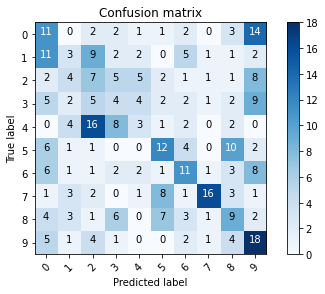

In [ ]:
np.set_printoptions(precision=2)

print (classification_report(y_test, preds_xgbc_g))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=['0','1','2','3','4','5','6','7','8','9'],normalize= False,  title='Confusion matrix')

#BRISK Tanpa Augmentasi

##Train Data

In [ ]:
dir = "/content/drive/MyDrive/Kelompok Visi Komputer/dataset/data train/"
folders = ['American craftsman style', 'Art Deco architecture', 'Art Nouveau architecture', 'Baroque architecture',
               'Beaux-Arts architecture', 'Deconstructivism', 'Greek Revival architecture', 'International style',
               'Novelty architecture', 'Queen Anne architecture']
IMAGE_SIZE = (150, 150)
features = []
labels = []
i = 0
counter = 0
for folder in folders:
  folder_dir = dir + folder
  images = Path(folder_dir).glob('*.jpg')
  for image in images:
    if counter < 86:
      image_pp = cv2.imread(str(image))
      image_pp = cv2.resize(image_pp, IMAGE_SIZE)
      image_pp = image_pp / 255.0
      image_pp = cv2.normalize(image_pp, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
      features.append(np.float32(getDes(image_pp, 'BRISK')))
      labels.append(i)
    counter = counter + 1
  i = i + 1
  counter = 0
features = np.vstack(features)

In [ ]:
k = 150
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.1)
flags = cv2.KMEANS_RANDOM_CENTERS
compactness, labels2, centres = cv2.kmeans(features, k, None, criteria, 10, flags)

In [ ]:
dir = "/content/drive/MyDrive/Kelompok Visi Komputer/dataset/data train/"
folders = ['American craftsman style', 'Art Deco architecture', 'Art Nouveau architecture', 'Baroque architecture',
               'Beaux-Arts architecture', 'Deconstructivism', 'Greek Revival architecture', 'International style',
               'Novelty architecture', 'Queen Anne architecture']
vec = []
i = 0
counter = 0
for folder in folders:
  folder_dir = dir + folder
  images = Path(folder_dir).glob('*.jpg')
  for image in images:
    if counter < 86:
      image_pp = cv2.imread(str(image))
      image_pp = cv2.resize(image_pp, IMAGE_SIZE)
      image_pp = image_pp / 255.0
      image_pp = cv2.normalize(image_pp, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
      img_des = getDes(image_pp, 'BRISK')
      if img_des is not None:
        img_vec = bag_of_features(img_des, centres, k)
        vec.append(img_vec)
    counter = counter + 1
  i = i + 1
  counter = 0
vec = np.vstack(vec)


In [ ]:
X_train = vec
y_train = labels

##Test Data

In [ ]:
dir = "/content/drive/MyDrive/Kelompok Visi Komputer/dataset/data test/"
folders = ['American craftsman style', 'Art Deco architecture', 'Art Nouveau architecture', 'Baroque architecture',
               'Beaux-Arts architecture', 'Deconstructivism', 'Greek Revival architecture', 'International style',
               'Novelty architecture', 'Queen Anne architecture']
vec = []
labels = []
i = 0
counter = 0
for folder in folders:
  folder_dir = dir + folder
  images = Path(folder_dir).glob('*.jpg')
  for image in images:
    if counter < 36:
      image_pp = cv2.imread(str(image))
      image_pp = cv2.cvtColor(image_pp, cv2.COLOR_BGR2RGB)
      image_pp = cv2.resize(image_pp, IMAGE_SIZE)
      image_pp = image_pp / 255.0
      image_pp = cv2.normalize(image_pp, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
      img_des = getDes(image_pp, 'BRISK')
      if img_des is not None:
        img_vec = bag_of_features(img_des, centres, k)
        vec.append(img_vec)
      labels.append(i)
    counter = counter + 1
  i = i + 1
  counter = 0
vec = np.vstack(vec)


In [ ]:
X_test = vec
y_test = labels

##Training Model dan Evaluasi

###SVC

In [ ]:
clf = SVC()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
acc = accuracy_score(y_test, preds)
conf_mat = confusion_matrix(y_test, preds)

              precision    recall  f1-score   support

           0       0.35      0.36      0.36        36
           1       0.21      0.14      0.17        36
           2       0.20      0.25      0.23        36
           3       0.37      0.31      0.33        36
           4       0.40      0.17      0.24        36
           5       0.41      0.44      0.43        36
           6       0.34      0.42      0.37        36
           7       0.53      0.50      0.51        36
           8       0.23      0.31      0.26        36
           9       0.27      0.33      0.30        36

    accuracy                           0.32       360
   macro avg       0.33      0.32      0.32       360
weighted avg       0.33      0.32      0.32       360

Confusion matrix, without normalization
[[13  1  0  0  0  1  5  0  6 10]
 [ 2  5 10  1  1  0  5  4  4  4]
 [ 1  3  9  7  4  1  2  1  2  6]
 [ 2  2  4 11  2  0  5  1  4  5]
 [ 1  3 14  6  6  1  3  1  0  1]
 [ 2  1  0  0  0 16  2  4  8  3]
 [ 

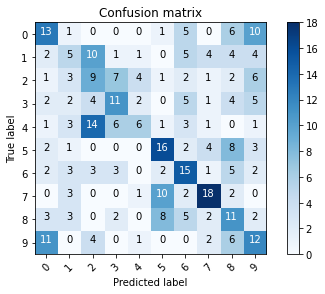

In [ ]:
np.set_printoptions(precision=2)

print (classification_report(y_test, preds))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=['0','1','2','3','4','5','6','7','8','9'],normalize= False,  title='Confusion matrix')

###Logistic Regression Grid Search

In [ ]:
param_grid = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
logreg=LogisticRegression()
model=GridSearchCV(logreg,param_grid)

In [ ]:
model.fit(X_train, y_train)
preds = model.predict(X_test)
acc = accuracy_score(y_test, preds)
conf_mat = confusion_matrix(y_test, preds)

              precision    recall  f1-score   support

           0       0.30      0.36      0.33        36
           1       0.21      0.17      0.18        36
           2       0.20      0.19      0.20        36
           3       0.28      0.31      0.29        36
           4       0.30      0.17      0.21        36
           5       0.19      0.14      0.16        36
           6       0.38      0.31      0.34        36
           7       0.51      0.61      0.56        36
           8       0.25      0.39      0.30        36
           9       0.23      0.25      0.24        36

    accuracy                           0.29       360
   macro avg       0.28      0.29      0.28       360
weighted avg       0.28      0.29      0.28       360

Confusion matrix, without normalization
[[13  0  0  1  1  2  2  1  6 10]
 [ 2  6  9  2  4  3  2  2  3  3]
 [ 3  4  7  5  5  3  2  0  2  5]
 [ 3  5  3 11  1  0  1  2  4  6]
 [ 0  3  9 10  6  3  1  4  0  0]
 [ 4  2  0  0  0  5  3  5 14  3]
 [ 

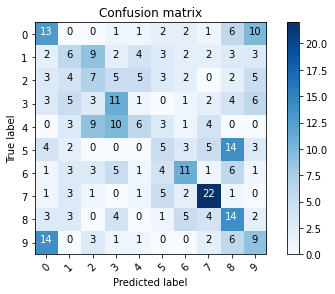

In [ ]:
np.set_printoptions(precision=2)

print (classification_report(y_test, preds))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=['0','1','2','3','4','5','6','7','8','9'],normalize= False,  title='Confusion matrix')

###Random Forest

In [ ]:
model = RandomForestClassifier(50, max_depth=15, max_features=15)
model.fit(X_train, y_train)
preds = model.predict(X_test)
acc = accuracy_score(y_test, preds)
conf_mat = confusion_matrix(y_test, preds)

              precision    recall  f1-score   support

           0       0.27      0.39      0.32        36
           1       0.13      0.08      0.10        36
           2       0.23      0.28      0.25        36
           3       0.28      0.25      0.26        36
           4       0.05      0.03      0.04        36
           5       0.37      0.47      0.41        36
           6       0.24      0.22      0.23        36
           7       0.61      0.53      0.57        36
           8       0.24      0.25      0.24        36
           9       0.17      0.19      0.18        36

    accuracy                           0.27       360
   macro avg       0.26      0.27      0.26       360
weighted avg       0.26      0.27      0.26       360

Confusion matrix, without normalization
[[14  0  0  0  1  1  3  0  6 11]
 [ 1  3  9  5  4  0  1  3  4  6]
 [ 4  3 10  4  4  0  2  1  3  5]
 [ 2  3  7  9  3  4  4  1  1  2]
 [ 1  5 11  6  1  0  4  3  0  5]
 [ 3  1  0  0  1 17  2  3  9  0]
 [ 

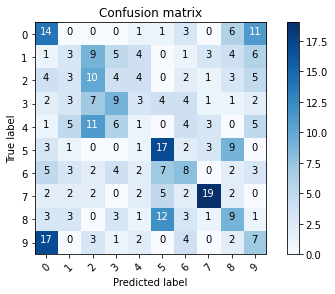

In [ ]:
np.set_printoptions(precision=2)

print (classification_report(y_test, preds))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=['0','1','2','3','4','5','6','7','8','9'],normalize= False,  title='Confusion matrix')

###XGBoost Grid Search

In [ ]:
xgbc = XGBClassifier(objective='multiclass:softmax', learning_rate = 0.1,
              max_depth = 1, n_estimators = 330)
param_grid={'learning_rate':[0.1,0.2,0.3,0.4,0.5,0.6]}

xgbc_g=GridSearchCV(xgbc,param_grid)
xgbc_g.fit(X_train, y_train)
preds_xgbc_g = xgbc_g.predict(X_test)

              precision    recall  f1-score   support

           0       0.26      0.31      0.28        36
           1       0.06      0.06      0.06        36
           2       0.13      0.11      0.12        36
           3       0.20      0.19      0.20        36
           4       0.30      0.22      0.25        36
           5       0.30      0.25      0.27        36
           6       0.33      0.33      0.33        36
           7       0.50      0.64      0.56        36
           8       0.12      0.14      0.13        36
           9       0.19      0.22      0.21        36

    accuracy                           0.25       360
   macro avg       0.24      0.25      0.24       360
weighted avg       0.24      0.25      0.24       360

Confusion matrix, without normalization
[[14  0  0  0  1  1  3  0  6 11]
 [ 1  3  9  5  4  0  1  3  4  6]
 [ 4  3 10  4  4  0  2  1  3  5]
 [ 2  3  7  9  3  4  4  1  1  2]
 [ 1  5 11  6  1  0  4  3  0  5]
 [ 3  1  0  0  1 17  2  3  9  0]
 [ 

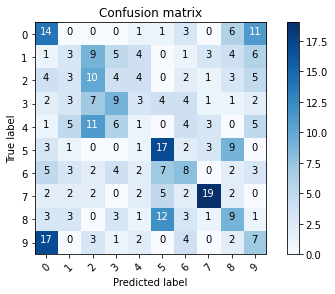

In [ ]:
np.set_printoptions(precision=2)

print (classification_report(y_test, preds_xgbc_g))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=['0','1','2','3','4','5','6','7','8','9'],normalize= False,  title='Confusion matrix')

#KAZE Dengan Augmentasi

##Train Data

In [ ]:
dir = "/content/drive/MyDrive/Kelompok Visi Komputer/dataset/data train/"
folders = ['American craftsman style', 'Art Deco architecture', 'Art Nouveau architecture', 'Baroque architecture',
               'Beaux-Arts architecture', 'Deconstructivism', 'Greek Revival architecture', 'International style',
               'Novelty architecture', 'Queen Anne architecture']
IMAGE_SIZE = (150, 150)
features = []
labels = []
i = 0
counter = 0
for folder in folders:
  folder_dir = dir + folder
  images = Path(folder_dir).glob('*.jpg')
  for image in images:
    if counter < 86:
      image_pp = cv2.imread(str(image))
      image_pp = cv2.resize(image_pp, IMAGE_SIZE)
      image_pp = image_pp / 255.0
      image_pp = cv2.normalize(image_pp, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
      features.append(np.float32(getDes(image_pp, 'KAZE')))
      labels.append(i)
      img = image_pp
      # Horizontal flip
      img_flip = cv2.flip(img, 1)
      features.append(np.float32(getDes(img_flip, 'KAZE')))
      labels.append(i)
      # Rotation
      angle = 45
      h, w = img.shape[:2]
      M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
      img_rotate = cv2.warpAffine(img, M, (w, h))
      features.append(np.float32(getDes(img_rotate, 'KAZE')))
      labels.append(i)
      # Zoom
      value = random.uniform(0.6, 1)
      h, w = img.shape[:2]
      h_taken = int(value*h)
      w_taken = int(value*w)
      h_start = random.randint(0, h-h_taken)
      w_start = random.randint(0, w-w_taken)
      img_con = img[h_start:h_start+h_taken, w_start:w_start+w_taken, :]
      img_zoom = fill(img_con, h, w)
      features.append(np.float32(getDes(img_zoom, 'KAZE')))
      labels.append(i)
      # Brighness
      value = random.uniform(0.5, 1.4)
      hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
      hsv = np.array(hsv, dtype = np.float64)
      hsv[:,:,1] = hsv[:,:,1]*value
      hsv[:,:,1][hsv[:,:,1]>255]  = 255
      hsv[:,:,2] = hsv[:,:,2]*value
      hsv[:,:,2][hsv[:,:,2]>255]  = 255
      hsv = np.array(hsv, dtype = np.uint8)
      img_bright = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
      features.append(np.float32(getDes(img_bright, 'KAZE')))
      labels.append(i)
    counter = counter + 1
  i = i + 1
  counter = 0
features = np.vstack(features)

In [ ]:
k = 150
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.1)
flags = cv2.KMEANS_RANDOM_CENTERS
compactness, labels2, centres = cv2.kmeans(features, k, None, criteria, 10, flags)

In [ ]:
dir = "/content/drive/MyDrive/Kelompok Visi Komputer/dataset/data train/"
folders = ['American craftsman style', 'Art Deco architecture', 'Art Nouveau architecture', 'Baroque architecture',
               'Beaux-Arts architecture', 'Deconstructivism', 'Greek Revival architecture', 'International style',
               'Novelty architecture', 'Queen Anne architecture']
vec = []
i = 0
counter = 0
for folder in folders:
  folder_dir = dir + folder
  images = Path(folder_dir).glob('*.jpg')
  for image in images:
    if counter < 86:
      image_pp = cv2.imread(str(image))
      image_pp = cv2.resize(image_pp, IMAGE_SIZE)
      image_pp = image_pp / 255.0
      image_pp = cv2.normalize(image_pp, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
      img_des = getDes(image_pp, 'KAZE')
      if img_des is not None:
        img_vec = bag_of_features(img_des, centres, k)
        vec.append(img_vec)
      img = image_pp
      # Horizontal flip
      img_flip = cv2.flip(img, 1)
      img_des = getDes(img_flip, 'KAZE')
      if img_des is not None:
        img_vec = bag_of_features(img_des, centres, k)
        vec.append(img_vec)
      # Rotation
      angle = 45
      h, w = img.shape[:2]
      M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
      img_rotate = cv2.warpAffine(img, M, (w, h))
      img_des = getDes(img_rotate, 'KAZE')
      if img_des is not None:
        img_vec = bag_of_features(img_des, centres, k)
        vec.append(img_vec)
      # Zoom
      value = random.uniform(0.6, 1)
      h, w = img.shape[:2]
      h_taken = int(value*h)
      w_taken = int(value*w)
      h_start = random.randint(0, h-h_taken)
      w_start = random.randint(0, w-w_taken)
      img_con = img[h_start:h_start+h_taken, w_start:w_start+w_taken, :]
      img_zoom = fill(img_con, h, w)
      img_des = getDes(img_zoom, 'KAZE')
      if img_des is not None:
        img_vec = bag_of_features(img_des, centres, k)
        vec.append(img_vec)
      # Brighness
      value = random.uniform(0.5, 1.4)
      hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
      hsv = np.array(hsv, dtype = np.float64)
      hsv[:,:,1] = hsv[:,:,1]*value
      hsv[:,:,1][hsv[:,:,1]>255]  = 255
      hsv[:,:,2] = hsv[:,:,2]*value
      hsv[:,:,2][hsv[:,:,2]>255]  = 255
      hsv = np.array(hsv, dtype = np.uint8)
      img_bright = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
      img_des = getDes(img_bright, 'KAZE')
      if img_des is not None:
        img_vec = bag_of_features(img_des, centres, k)
        vec.append(img_vec)
    counter = counter + 1
  i = i + 1
  counter = 0
vec = np.vstack(vec)


In [ ]:
X_train = vec
y_train = labels

##Test Data

In [ ]:
dir = "/content/drive/MyDrive/Kelompok Visi Komputer/dataset/data test/"
folders = ['American craftsman style', 'Art Deco architecture', 'Art Nouveau architecture', 'Baroque architecture',
               'Beaux-Arts architecture', 'Deconstructivism', 'Greek Revival architecture', 'International style',
               'Novelty architecture', 'Queen Anne architecture']
vec = []
labels = []
i = 0
counter = 0
for folder in folders:
  folder_dir = dir + folder
  images = Path(folder_dir).glob('*.jpg')
  for image in images:
    if counter < 36:
      image_pp = cv2.imread(str(image))
      image_pp = cv2.cvtColor(image_pp, cv2.COLOR_BGR2RGB)
      image_pp = cv2.resize(image_pp, IMAGE_SIZE)
      image_pp = image_pp / 255.0
      image_pp = cv2.normalize(image_pp, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
      img_des = getDes(image_pp, 'KAZE')
      if img_des is not None:
        img_vec = bag_of_features(img_des, centres, k)
        vec.append(img_vec)
      labels.append(i)
    counter = counter + 1
  i = i + 1
  counter = 0
vec = np.vstack(vec)


In [ ]:
X_test = vec
y_test = labels

##Training Model dan Evaluasi

###SVC

In [ ]:
clf = SVC()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
acc = accuracy_score(y_test, preds)
conf_mat = confusion_matrix(y_test, preds)

ValueError: ignored

In [ ]:
np.set_printoptions(precision=2)

print (classification_report(y_test, preds))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=['0','1','2','3','4','5','6','7','8','9'],normalize= False,  title='Confusion matrix')

###Logistic Regression Grid Search

In [ ]:
param_grid = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
logreg=LogisticRegression()
model=GridSearchCV(logreg,param_grid)

In [ ]:
model.fit(X_train, y_train)
preds = model.predict(X_test)
acc = accuracy_score(y_test, preds)
conf_mat = confusion_matrix(y_test, preds)

In [ ]:
np.set_printoptions(precision=2)

print (classification_report(y_test, preds))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=['0','1','2','3','4','5','6','7','8','9'],normalize= False,  title='Confusion matrix')

###Random Forest

In [ ]:
model = RandomForestClassifier(50, max_depth=15, max_features=15)
model.fit(X_train, y_train)
preds = model.predict(X_test)
acc = accuracy_score(y_test, preds)
conf_mat = confusion_matrix(y_test, preds)

In [ ]:
np.set_printoptions(precision=2)

print (classification_report(y_test, preds))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=['0','1','2','3','4','5','6','7','8','9'],normalize= False,  title='Confusion matrix')

###XGBoost Grid Search

In [ ]:
xgbc = XGBClassifier(objective='multiclass:softmax', learning_rate = 0.1,
              max_depth = 1, n_estimators = 330)
param_grid={'learning_rate':[0.1,0.2,0.3,0.4,0.5,0.6]}

xgbc_g=GridSearchCV(xgbc,param_grid)
xgbc_g.fit(X_train, y_train)
preds_xgbc_g = xgbc_g.predict(X_test)

In [ ]:
np.set_printoptions(precision=2)

print (classification_report(y_test, preds_xgbc_g))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=['0','1','2','3','4','5','6','7','8','9'],normalize= False,  title='Confusion matrix')

#KAZE Tanpa Augmentasi

##Train Data

In [ ]:
dir = "/content/drive/MyDrive/Kelompok Visi Komputer/dataset/data train/"
folders = ['American craftsman style', 'Art Deco architecture', 'Art Nouveau architecture', 'Baroque architecture',
               'Beaux-Arts architecture', 'Deconstructivism', 'Greek Revival architecture', 'International style',
               'Novelty architecture', 'Queen Anne architecture']
IMAGE_SIZE = (150, 150)
features = []
labels = []
i = 0
counter = 0
for folder in folders:
  folder_dir = dir + folder
  images = Path(folder_dir).glob('*.jpg')
  for image in images:
    if counter < 86:
      image_pp = cv2.imread(str(image))
      image_pp = cv2.resize(image_pp, IMAGE_SIZE)
      image_pp = image_pp / 255.0
      image_pp = cv2.normalize(image_pp, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
      features.append(np.float32(getDes(image_pp, 'KAZE')))
      labels.append(i)
    counter = counter + 1
  i = i + 1
  counter = 0
features = np.vstack(features)

In [ ]:
k = 150
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.1)
flags = cv2.KMEANS_RANDOM_CENTERS
compactness, labels2, centres = cv2.kmeans(features, k, None, criteria, 10, flags)

In [ ]:
dir = "/content/drive/MyDrive/Kelompok Visi Komputer/dataset/data train/"
folders = ['American craftsman style', 'Art Deco architecture', 'Art Nouveau architecture', 'Baroque architecture',
               'Beaux-Arts architecture', 'Deconstructivism', 'Greek Revival architecture', 'International style',
               'Novelty architecture', 'Queen Anne architecture']
vec = []
i = 0
counter = 0
for folder in folders:
  folder_dir = dir + folder
  images = Path(folder_dir).glob('*.jpg')
  for image in images:
    if counter < 86:
      image_pp = cv2.imread(str(image))
      image_pp = cv2.resize(image_pp, IMAGE_SIZE)
      image_pp = image_pp / 255.0
      image_pp = cv2.normalize(image_pp, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
      img_des = getDes(image_pp, 'KAZE')
      if img_des is not None:
        img_vec = bag_of_features(img_des, centres, k)
        vec.append(img_vec)
    counter = counter + 1
  i = i + 1
  counter = 0
vec = np.vstack(vec)


In [ ]:
X_train = vec
y_train = labels

##Test Data

In [ ]:
dir = "/content/drive/MyDrive/Kelompok Visi Komputer/dataset/data test/"
folders = ['American craftsman style', 'Art Deco architecture', 'Art Nouveau architecture', 'Baroque architecture',
               'Beaux-Arts architecture', 'Deconstructivism', 'Greek Revival architecture', 'International style',
               'Novelty architecture', 'Queen Anne architecture']
vec = []
labels = []
i = 0
counter = 0
for folder in folders:
  folder_dir = dir + folder
  images = Path(folder_dir).glob('*.jpg')
  for image in images:
    if counter < 36:
      image_pp = cv2.imread(str(image))
      image_pp = cv2.cvtColor(image_pp, cv2.COLOR_BGR2RGB)
      image_pp = cv2.resize(image_pp, IMAGE_SIZE)
      image_pp = image_pp / 255.0
      image_pp = cv2.normalize(image_pp, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
      img_des = getDes(image_pp, 'KAZE')
      if img_des is not None:
        img_vec = bag_of_features(img_des, centres, k)
        vec.append(img_vec)
      labels.append(i)
    counter = counter + 1
  i = i + 1
  counter = 0
vec = np.vstack(vec)


In [ ]:
X_test = vec
y_test = labels

##Training Model dan Evaluasi

###SVC

In [ ]:
clf = SVC()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
acc = accuracy_score(y_test, preds)
conf_mat = confusion_matrix(y_test, preds)

In [ ]:
np.set_printoptions(precision=2)

print (classification_report(y_test, preds))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=['0','1','2','3','4','5','6','7','8','9'],normalize= False,  title='Confusion matrix')

###Logistic Regression Grid Search

In [ ]:
param_grid = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
logreg=LogisticRegression()
model=GridSearchCV(logreg,param_grid)

In [ ]:
model.fit(X_train, y_train)
preds = model.predict(X_test)
acc = accuracy_score(y_test, preds)
conf_mat = confusion_matrix(y_test, preds)

In [ ]:
np.set_printoptions(precision=2)

print (classification_report(y_test, preds))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=['0','1','2','3','4','5','6','7','8','9'],normalize= False,  title='Confusion matrix')

###Random Forest

In [ ]:
model = RandomForestClassifier(50, max_depth=15, max_features=15)
model.fit(X_train, y_train)
preds = model.predict(X_test)
acc = accuracy_score(y_test, preds)
conf_mat = confusion_matrix(y_test, preds)

In [ ]:
np.set_printoptions(precision=2)

print (classification_report(y_test, preds))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=['0','1','2','3','4','5','6','7','8','9'],normalize= False,  title='Confusion matrix')

###XGBoost Grid Search

In [ ]:
xgbc = XGBClassifier(objective='multiclass:softmax', learning_rate = 0.1,
              max_depth = 1, n_estimators = 330)
param_grid={'learning_rate':[0.1,0.2,0.3,0.4,0.5,0.6]}

xgbc_g=GridSearchCV(xgbc,param_grid)
xgbc_g.fit(X_train, y_train)
preds_xgbc_g = xgbc_g.predict(X_test)

In [ ]:
np.set_printoptions(precision=2)

print (classification_report(y_test, preds_xgbc_g))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=['0','1','2','3','4','5','6','7','8','9'],normalize= False,  title='Confusion matrix')

In [ ]:
count_0 = 0
count_1 = 0
count_2 = 0
count_3 = 0
count_4 = 0
count_5 = 0
count_6 = 0
count_7 = 0
count_8 = 0
count_9 = 0

for n in y_train:
  if n == 0:
    count_0 = count_0 + 1
  if n == 1:
    count_1 = count_1 + 1
  if n == 2:
    count_2 = count_2 + 1
  if n == 3:
    count_3 = count_3 + 1
  if n == 4:
    count_4 = count_4 + 1
  if n == 5:
    count_5 = count_5 + 1
  if n == 6:
    count_6 = count_6 + 1
  if n == 7:
    count_7 = count_7 + 1
  if n == 8:
    count_8 = count_8 + 1
  if n == 9:
    count_9 = count_9 + 1

print(count_0)
print(count_1)
print(count_2)
print(count_3)
print(count_4)
print(count_5)
print(count_6)
print(count_7)
print(count_8)
print(count_9)

In [ ]:
count_0 = 0
count_1 = 0
count_2 = 0
count_3 = 0
count_4 = 0
count_5 = 0
count_6 = 0
count_7 = 0
count_8 = 0
count_9 = 0

for n in y_test:
  if n == 0:
    count_0 = count_0 + 1
  if n == 1:
    count_1 = count_1 + 1
  if n == 2:
    count_2 = count_2 + 1
  if n == 3:
    count_3 = count_3 + 1
  if n == 4:
    count_4 = count_4 + 1
  if n == 5:
    count_5 = count_5 + 1
  if n == 6:
    count_6 = count_6 + 1
  if n == 7:
    count_7 = count_7 + 1
  if n == 8:
    count_8 = count_8 + 1
  if n == 9:
    count_9 = count_9 + 1

print(count_0)
print(count_1)
print(count_2)
print(count_3)
print(count_4)
print(count_5)
print(count_6)
print(count_7)
print(count_8)
print(count_9)